<a href="https://colab.research.google.com/github/tbrunetti/nvida_ai_ml_series/blob/main/intro_to_monai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to MONAI**
### *Michaela Buchanan - Mark III Systems*

Imports for all the code below. Please run first before anything else and remember that the order in which you run code cells matters!

In [ ]:
!pip install -q "monai-weekly[pillow, tqdm]"
!pip install -q matplotlib
!pip install -q itk
%matplotlib inline

import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np

from monai.config import print_config
from monai.transforms import (
    EnsureChannelFirst,
    LoadImage,
    RandRotate,
    Orientation,
    GaussianSmooth,
    Compose
)

import nibabel as nib
from google.colab.patches import cv2_imshow

print_config()

!git clone https://github.com/michaelabuchanan/monai_workshop

MONAI version: 1.2.dev2301
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: bd2e08c2ab5130e3ed58f1cdd6b864f98add2c89
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

fatal: destination path '

---

### Importing NIfTI files

In the cell above we imported all of the Python libraries we need for this notebook. We also cloned a GitHub repository I made which contains the scans we will be using as examples. The first scan we are looking at is of an iguana and comes from [*this GitHub repository*](https://github.com/neurolabusc/niivue-images). Visit this site to find more sample NIfTI files to experiment with.

Let's take a look at the scan we just downloaded using the MONAI library. To do this we are creating a `LoadImage` object which we are loading into our own `loader` variable and giving it the path to our Iguana scan. It handles all the work of turning our scan into a `torch` object which would be easy to feed into a PyTorch neural network. Then we can print out the shape of the scan and the metadata associated with this file. Note that the affine array is printed out from the `meta` variable.

In [ ]:
loader = LoadImage(dtype=np.float32)

iguana_scan, meta = loader('/content/monai_workshop/Iguana.nii.gz')

print(iguana_scan.shape)
print(meta)

torch.Size([210, 256, 179])
{'sizeof_hdr': array(348, dtype=int32), 'extents': array(0, dtype=int32), 'session_error': array(0, dtype=int16), 'dim_info': array(0, dtype=uint8), 'dim': array([  3, 210, 256, 179,   1,   1,   1,   1], dtype=int16), 'intent_p1': array(0., dtype=float32), 'intent_p2': array(0., dtype=float32), 'intent_p3': array(0., dtype=float32), 'intent_code': array(0, dtype=int16), 'datatype': array(2, dtype=int16), 'bitpix': array(8, dtype=int16), 'slice_start': array(0, dtype=int16), 'pixdim': array([1.        , 0.10180002, 0.10180002, 0.10180002, 1.        ,
       0.        , 0.        , 0.        ], dtype=float32), 'vox_offset': array(0., dtype=float32), 'scl_slope': array(nan, dtype=float32), 'scl_inter': array(nan, dtype=float32), 'slice_end': array(0, dtype=int16), 'slice_code': array(0, dtype=uint8), 'xyzt_units': array(10, dtype=uint8), 'cal_max': array(0., dtype=float32), 'cal_min': array(0., dtype=float32), 'slice_duration': array(0., dtype=float32), 'toffse

Now let's look at the scan itself. Since the scan is a 3D array we can get 2D slices of it by restraining one of the dimensions of our array. Below is a plot demonstrating this - note how each of the `scan_slice` variables restrains a different dimension. You should be able to see how we are viewing each of these slices from a different angle. As the scan is a 3D object, changing your viewpoint orientation can make the slices look very different from each other.

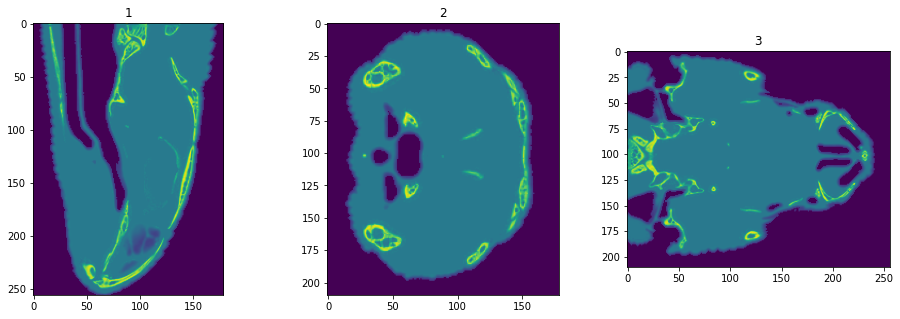

In [ ]:
# making scan slices
scan_slice1 = iguana_scan[100, :, :] #restrain x
scan_slice2 = iguana_scan[:, 100, :] #restrain y
scan_slice3 = iguana_scan[:, :, 100] #restrain z

# plotting the slices
iguana_plot, iguana_axes = plt.subplots(1, 3, figsize=(16, 5))
iguana_axes[0].set_title("1")
iguana_axes[0].imshow(scan_slice1)
iguana_axes[1].set_title("2")
iguana_axes[1].imshow(scan_slice2)
iguana_axes[2].set_title("3")
iguana_axes[2].imshow(scan_slice3)
iguana_plot.show()

While the Iguana scan is fun, let's load an example of a scan paired with a segmentation mask. The idea is that a subject matter expert looks at an MRI scan and finds ROIs (regions of interest). These could be tumors in cancer scans or organs we want to be able to distinguish from the rest of the scan just to name two examples. The hope is that if we feed enough pairs of scans and their ROIs to a neural network it will be able to find reasonable ROIs for us in new scans. 

For this example we have a chest CT scan and a mask that marks ROIs for studying the impacts of COVID. These examples are from [*this Kaggle dataset*](https://www.kaggle.com/datasets/mathurinache/mosmeddata-chest-ct-scans-with-covid19). The scan and the mask are in two seperate files that we will load in with the same `loader` we created for our Iguana scan. Just like before we will get torch objects as a result. It's a good idea to double check that the actual scan (which will be refered to as the `target` scan from now on) and the mask are the same shape.

In [ ]:
target, t_meta = loader('/content/monai_workshop/study_0255.nii')
mask, m_meta = loader('/content/monai_workshop/study_0255_mask.nii')

print(target.shape)
print(mask.shape)

torch.Size([512, 512, 38])
torch.Size([512, 512, 38])


Now let's plot some slices from our scans to visualize them. This is done in the same way as before. We take both slices at Z=16 and then plot them next to each other. If you look closely, you should be able to see some faint fuzziness on the target scan in the same shape and location as the highlighted parts of the mask. In other words, it looks like we would be able to put the mask over the target scan and highlight things that actually exist in the scan. This tells us that our scan and mask line up which is extremely important if we want to use them for training a segmentation model.

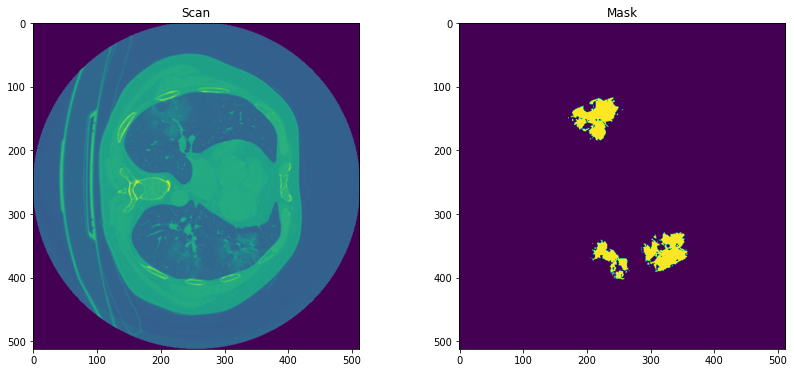

In [ ]:
# making scan slices
target_slice = target[:, :, 16]
mask_slice = mask[:, :, 16]

# plotting the slices
plot1, axes1 = plt.subplots(1, 2, figsize=(14, 6))
axes1[0].set_title("Scan")
axes1[0].imshow(target_slice)
axes1[1].set_title("Mask")
axes1[1].imshow(mask_slice)
plot1.show()

---

### 3D Scan Orientation

As you might remember from the lecture portion of this workshop, we need our data to be in *channel-first* format to smoothly perform our tranforms and to ensure loading the scan into PyTorch works as expected. Since our scans are in grayscale, our channel number is 1. If it was a colored scan we would have 3 channels, one for each RGB channel.

MONAI has a built-in function called `EnsureChannelFirst()` which makes changing our scan to "channel-first" format very easy. You can see by the shapes of our scans after feeding them through `ensure_channel_first` that we successfully added a dimension to the beginning of our arrays which contains the number 1.

In [ ]:
ensure_channel_first = EnsureChannelFirst()
target_scan = ensure_channel_first(target)
mask_scan = ensure_channel_first(mask)

print(target_scan.shape)
print(mask_scan.shape)

torch.Size([1, 512, 512, 38])
torch.Size([1, 512, 512, 38])


Now we are going to create an `Orientation` object to perform to change the orientation of our scan. We also need to perform the same operation on our mask to ensure it still lines up with our scan. The `Orientation` object takes an `axcodes` argument in which you can set what orientiation you want your scan in. In the example below we give it `LPS` which indicates we want **L**eft, **P**osterior, **S**uperior orientation. The opposite of this would be `RAI`, which would give us scans in **R**ight, **A**nterior, **I**nferior orientation. I encourage you to try changing the axcodes to see the effect it has on the transformation applied. 

In [ ]:
orientation = Orientation(axcodes="LPS") # left, posterior, superior

or_target = orientation(target_scan)
or_mask = orientation(mask_scan)

Now let's take a look at our reoriented scan and mask and compare them to the ones we looked at before. First we take slices of the rotated scans so we can display them as images. We will take slice Z=16 just like we did in displaying the slices before.

In order to display our images we need to turn our scan slices back into 3 dimensional arrays. This means we are just going to get rid of the first dimension we added for our channel in doing our `EnsureChannelFirst` operation. The Numpy library provides a convienient function called `squeeze` which gets rid of any dimensions of our array that are 1 so that's what we are using in the code cell below. Then a plot is made which shows first our original two scans followed by our reoriented scans.

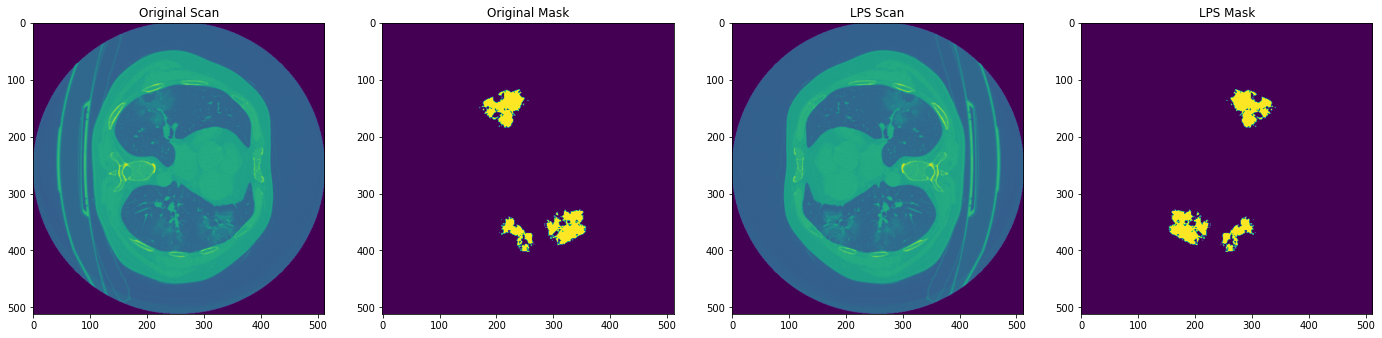

In [ ]:
or_target_slice = or_target[:,: ,:, 16]
or_mask_slice = or_mask[:, :, :, 16]

or_target_slice = np.squeeze(or_target_slice)
or_mask_slice = np.squeeze(or_mask_slice)

# plotting the slices
plot2, axes2 = plt.subplots(1, 4, figsize=(24, 6))
axes2[0].set_title("Original Scan")
axes2[0].imshow(target_slice)
axes2[1].set_title("Original Mask")
axes2[1].imshow(mask_slice)
axes2[2].set_title("LPS Scan")
axes2[2].imshow(or_target_slice)
axes2[3].set_title("LPS Mask")
axes2[3].imshow(or_mask_slice)
plot2.show()

As you can see, when we use the LPS orientation we get a mirror image of our original scans. Note that our mask is also flipped in the same way as our scan which is super important. If our mask no longer lines up with our scan then it becomes useless to us as a mask. 

While doing these reorientations can be very useful for inspecting scans or creating consistent orientation in a collection of scans, it can be limiting as a dataset augmentation tool. If we open up our rotation possibilities to any rotation rather than just on preset axis we can create a much larger set of samples. 

---

### 3D Scan Random Rotations

A common way to make a small dataset go further for model training is to create variations of the datapoints you have to increase your total number of datapoints. The challenge is that one must balance creating unique enough variations to make them different enough from the originals while not changing them so drastically that they don't provide any learning value anymore. 

We are going to be using MONAI's `RandRotate` function to augment our scans. This function will perform a random rotation along a user specified axis. The process is going to be very similar to performing our reorientations earlier.

In the code cell below we create a `RandRotate` object with two arguments. The first, `prob`, is the probability that this transformation will do a rotation. We have this set to 1 as we always want it to do a rotation. Then we give it a range of possible rotations by setting `range_z` to 0.3 - 1. This means that this tranformation will choose a random rotation in this range and perform it on the Z axis. Note that this range is in radians. You can do the same for the X or the Y axis. We then apply this tranformation to both our target and mask scans. 

In [ ]:
rotator = RandRotate(prob=1, range_z=[0.3, 1])
r_target = rotator(target_scan)
r_mask = rotator(mask_scan)

print(r_target.shape)
print(r_mask.shape)

torch.Size([1, 512, 512, 38])
torch.Size([1, 512, 512, 38])


Now let's look at our results. We repeat the same process as before of taking our slices, using `np.squeeze()`, and then plotting the slices. You should be able to see a difference in rotation between the original and the new slices for both the target scan and the masks. The new rotated mask also still lines up with the new rotated target scan meaning this data should still be usable to train a segmentation model.

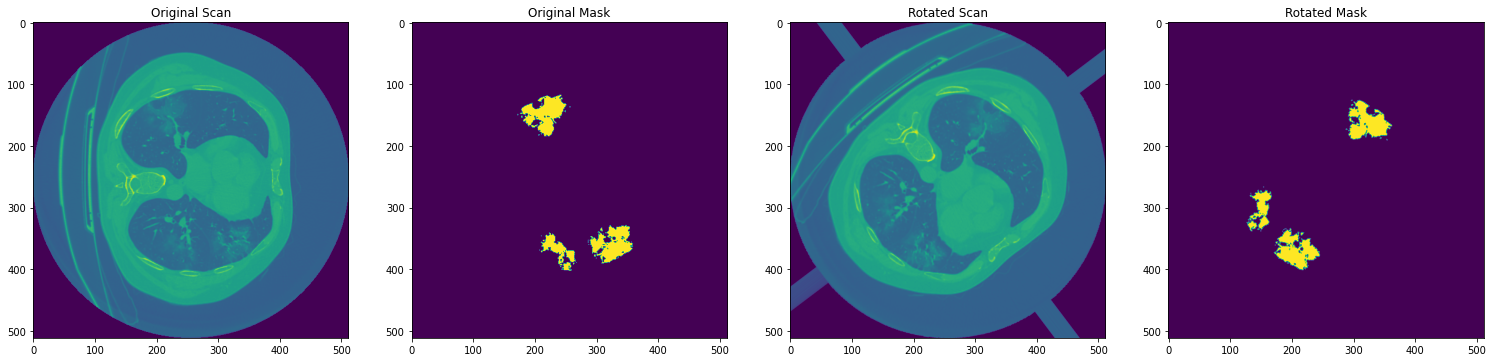

In [ ]:
r_target_slice = r_target[:, : ,:, 16]
r_mask_slice = r_mask[:, :, :, 16]

r_target_slice = np.squeeze(r_target_slice)
r_mask_slice = np.squeeze(r_mask_slice)

# plotting the slices
plot3, axes3 = plt.subplots(1, 4, figsize=(26, 6))
axes3[0].set_title("Original Scan")
axes3[0].imshow(target_slice)
axes3[1].set_title("Original Mask")
axes3[1].imshow(mask_slice)
axes3[2].set_title("Rotated Scan")
axes3[2].imshow(r_target_slice)
axes3[3].set_title("Rotated Mask")
axes3[3].imshow(r_mask_slice)
plot3.show()

---

### Stringing together Transforms with `Compose()`

There's a good chance that you will want to apply more than one tranformation at a time to one or multiple scans in your dataset. While you could write code in the format we've seen so far, MONAI provides a function called `Compose()` to make this process a lot more efficient. Below is an example using this function. All we do is store the `Compose` call into a variable (called `tranforms` in this example) and list out the transformations we would like to apply. 

Here we are going to apply `EnsureChannelFirst()` followed by a `RandRotate()` and then a new transformation, `GaussianSmooth()`. All `GaussianSmooth()` does is apply a smoothing filter over our scan. 

Let's try it out with the Iguana scan from the beginning of this workshop. We load it into our `tranforms()` function and the result should have all our tranformations applied to it.

In [ ]:
transforms = Compose(
    [
        EnsureChannelFirst(),
        RandRotate(prob=1, range_z=[0.3, 1]),
        GaussianSmooth()
    ]
)

iguana_transformed = transforms(iguana_scan)
print(iguana_transformed.shape)

torch.Size([1, 210, 256, 179])


Just like before we do our `np.squeeze` operation and take a slice of our scan. The plot below compares the original scan and the new transformed scan both sliced at Z=100. You should see the new scan slice is indeed rotated and looks blurry due to the smoothing transform we applied.

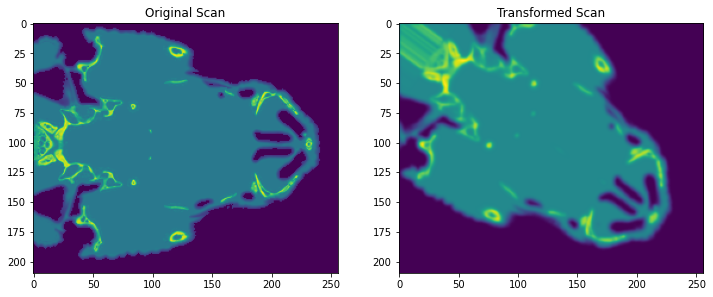

In [ ]:
iguana_slice = np.squeeze(iguana_transformed)
iguana_slice = iguana_slice[:, :, 100]

# plotting the slices
plot4, axes4 = plt.subplots(1, 2, figsize=(12, 12))
axes4[0].set_title("Original Scan")
axes4[0].imshow(scan_slice3)
axes4[1].set_title("Transformed Scan")
axes4[1].imshow(iguana_slice)
plot4.show()

---

### Helpful Resources

Here are some tutorial notebooks provided by MONAI that are relavent to the topics we discussed during this session. The last link will take you to a page with all of MONAI's tutorial notebooks. There are a ton of notebooks provided so it's a great place to check to see if there's an example similar to the project you are trying to undertake.



*   Importing different image data formats: https://github.com/Project-MONAI/tutorials/blob/main/modules/load_medical_images.ipynb 
*   3D NIfTI Transforms: https://github.com/Project-MONAI/tutorials/blob/main/modules/3d_image_transforms.ipynb 
*   All MONAI tutorial notebooks: https://github.com/Project-MONAI/tutorials



This is a list of resources I found helpful while creating this course.

*   MONAI Transforms documentation: https://docs.monai.io/en/stable/transforms.html#
*   NiBabel Affine Matrix Tutorial: https://nipy.org/nibabel/coordinate_systems.html
*   NiBabel tutorial video: https://www.youtube.com/watch?v=Y6ulmOlW1FI&ab_channel=UWeScienceInstitute 
*   3D Classification Tutorial for Keras: https://keras.io/examples/vision/3D_image_classification/
*   Paper comparing 2D vs 3D brain scan segmentation models: https://www.medrxiv.org/content/10.1101/2022.11.03.22281923v1.full 